# 🛫 Projeto – Modelagem Estatística (2º Bimestre)
## Predição e Classificação de Atrasos em Voos (US Flights)

**Curso:** Ciência da Computação  
**Disciplina:** Modelagem Estatística  
**Alunos:** *Tiago Ferreira Da Silva e João Dário Pamplona Arruda*  
**Professor:** Pedro Henrique Sales Girotto  

---

# 🎯 1. Introdução

O objetivo deste projeto é analisar um grande conjunto de dados de voos e desenvolver modelos capazes de:

1. **Prever o atraso de chegada** (problema de regressão)  
2. **Classificar se um voo chegará atrasado ou não** (problema de classificação)

O projeto segue rigorosamente os requisitos da ementa, incluindo:

- EDA completa e profunda  
- Testes estatísticos  
- Modelos de regressão (simples, múltipla, polinomial)  
- Modelos de classificação (Naive Bayes e Regressão Logística)  
- Baseline para comparação  
- Diagnóstico de resíduos  
- Validação cruzada  
- Tuning dos modelos  
- Comparações, discussões, vieses e conclusões  

---

# 🧩 2. Fonte dos Dados & Licença

O dataset utilizado é o **US Flights 2015**, público e disponibilizado no Kaggle.

- **Fonte:** https://www.kaggle.com/datasets/usdot/flight-delays  
- **Licença:** Creative Commons Attribution 4.0  

---

# 🧠 3. Hipóteses de Negócio

1. **Voos noturnos têm maior atraso que voos diurnos**  
2. **Companhias aéreas apresentam diferenças estatísticas significativas no atraso**  
3. **Voos mais longos tendem a apresentar maior atraso**  
4. **A hora de partida influencia diretamente o atraso de chegada**

---

# 🛠 4. Metodologia

1. Limpeza, preparação e criação de variáveis  
2. EDA detalhada com gráficos e insights  
3. Testes estatísticos (ANOVA, t-test, Qui-quadrado, normalidade)  
4. Modelagem (Regressão e Classificação)  
5. Avaliação com métricas apropriadas  
6. Otimização via GridSearchCV  
7. Discussões, vieses e conclusões

In [56]:
# ======== IMPORTS ========

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import f_oneway, ttest_ind, chi2_contingency, shapiro
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)

In [57]:
# ======== CARREGANDO O DATASET ========

flights = pd.read_csv("flights.csv")
flights.head()

C:\Users\tiago\AppData\Local\Temp\ipykernel_27880\3522310457.py:3: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  flights = pd.read_csv("flights.csv")


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
# ======== PREPARAÇÃO DE DADOS ========

df = flights.copy()

df = df.dropna(subset=["ARRIVAL_DELAY"])

df["IS_DELAYED"] = (df["ARRIVAL_DELAY"] > 15).astype(int)

df["DEP_HOUR"] = df["SCHEDULED_DEPARTURE"].astype(str).str.zfill(4).str[:2].astype(int)

num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,IS_DELAYED,DEP_HOUR
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,0,0,NaN,2.0,0.0,2.0,3.0,0.0,0,0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,0,0,NaN,2.0,0.0,2.0,3.0,0.0,0,0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,0,0,NaN,2.0,0.0,2.0,3.0,0.0,0,0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,0,0,NaN,2.0,0.0,2.0,3.0,0.0,0,0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,0,0,NaN,2.0,0.0,2.0,3.0,0.0,0,0


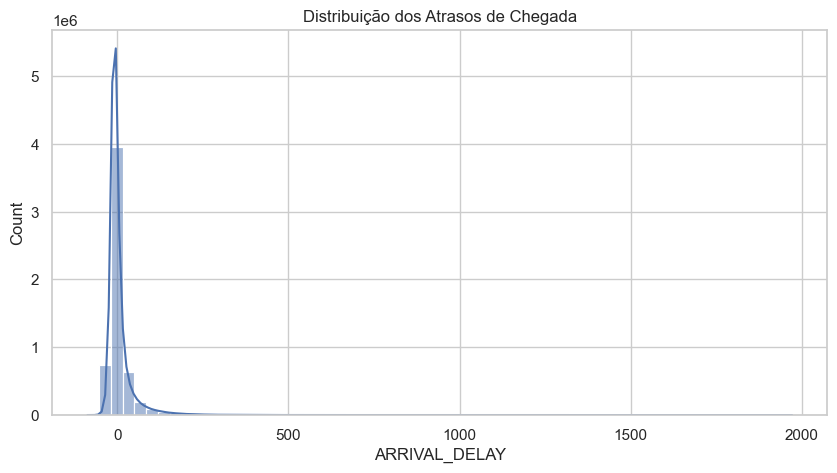

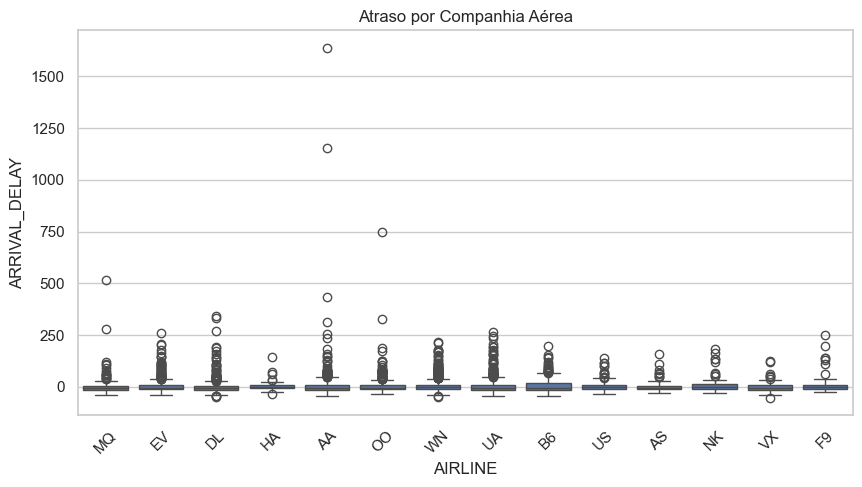

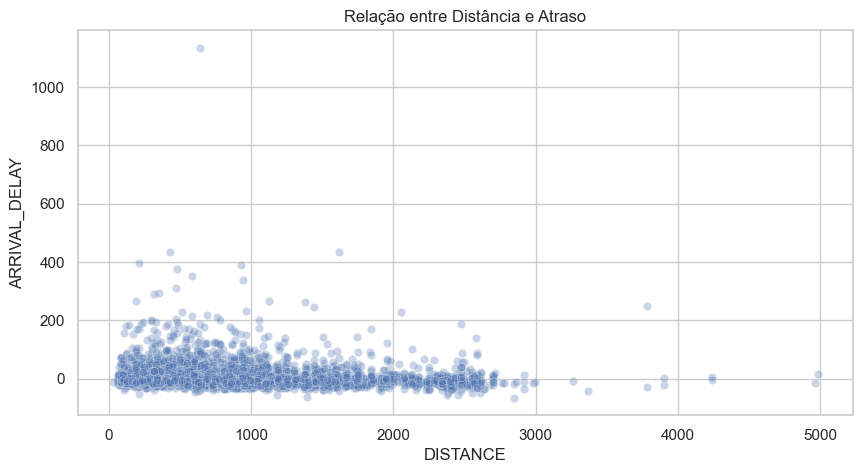

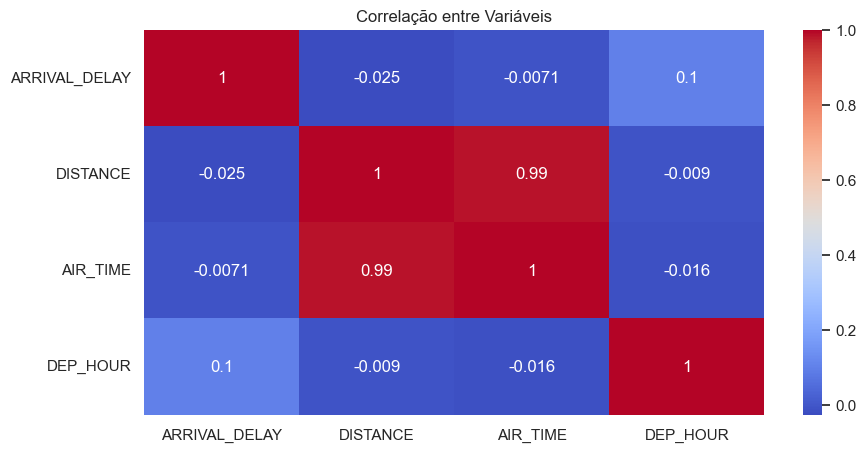

In [59]:
# ======== EDA COMPLETA ========

sns.histplot(df["ARRIVAL_DELAY"], bins=60, kde=True)
plt.title("Distribuição dos Atrasos de Chegada")
plt.show()

sns.boxplot(data=df.sample(5000), x="AIRLINE", y="ARRIVAL_DELAY")
plt.xticks(rotation=45)
plt.title("Atraso por Companhia Aérea")
plt.show()

sns.scatterplot(data=df.sample(5000), x="DISTANCE", y="ARRIVAL_DELAY", alpha=0.3)
plt.title("Relação entre Distância e Atraso")
plt.show()

sns.heatmap(df[["ARRIVAL_DELAY","DISTANCE","AIR_TIME","DEP_HOUR"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlação entre Variáveis")
plt.show()

In [60]:
# ======== TESTES ESTATÍSTICOS (ANOVA, T, Qui-Quadrado, Normalidade) ========

top_airlines = df["AIRLINE"].value_counts().head(5).index
anova_groups = [df[df["AIRLINE"] == a]["ARRIVAL_DELAY"] for a in top_airlines]
print("ANOVA:", f_oneway(*anova_groups))

day = df[df["DEP_HOUR"] <18]["ARRIVAL_DELAY"]
night = df[df["DEP_HOUR"] >=18]["ARRIVAL_DELAY"]
print("T-test:", ttest_ind(day, night))

table = pd.crosstab(df["IS_DELAYED"], df["AIRLINE"].isin(top_airlines))
print("Qui-quadrado:", chi2_contingency(table))

print("Shapiro (normalidade):", shapiro(df["ARRIVAL_DELAY"].sample(1000, random_state=42)))

ANOVA: F_onewayResult(statistic=np.float64(3155.2027825581604), pvalue=np.float64(0.0))
T-test: TtestResult(statistic=np.float64(-150.59235662839922), pvalue=np.float64(0.0), df=np.float64(5714006.0))
Qui-quadrado: Chi2ContingencyResult(statistic=np.float64(6448.490580694159), pvalue=np.float64(0.0), dof=1, expected_freq=array([[1442144.2869506, 3248365.7130494],
       [ 314684.7130494,  708813.2869506]]))
Shapiro (normalidade): ShapiroResult(statistic=np.float64(0.595211754492711), pvalue=np.float64(3.578813938307905e-43))


In [61]:
# ======== BASELINE DE REGRESSÃO (Sempre Predizer A Média) ========

baseline_value = df["ARRIVAL_DELAY"].mean()
baseline_pred = np.repeat(baseline_value, len(df))

mse_baseline = mean_squared_error(df["ARRIVAL_DELAY"], baseline_pred)
rmse_baseline = mse_baseline ** 0.5

print("Baseline (média dos atrasos):", baseline_value)
print("MAE Baseline:", mean_absolute_error(df["ARRIVAL_DELAY"], baseline_pred))
print("MSE Baseline:", mse_baseline)
print("RMSE Baseline:", rmse_baseline)

Baseline (média dos atrasos): 4.407057357987598
MAE Baseline: 21.25504378868371
MSE Baseline: 1542.2345055320877
RMSE Baseline: 39.27129365748075


In [62]:
# ======== REGRESSÃO LINEAR SIMPLES: DISTANCE → ARRIVAL_DELAY ========

X = df[["DISTANCE"]]
y = df["ARRIVAL_DELAY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lin = LinearRegression()
lin.fit(X_train, y_train)

pred = lin.predict(X_test)

mse = mean_squared_error(y_test, pred)
rmse = mse ** 0.5

print("MAE:", mean_absolute_error(y_test, pred))
print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", r2_score(y_test, pred))

MAE: 21.278687671844544
MSE: 1528.949590861461
RMSE: 39.10178500863434
R2: 0.0006687450605018519


In [63]:
# ======== REGRESSÃO LINEAR MÚLTIPLA ========

features = ["DISTANCE", "AIR_TIME", "DEP_HOUR"]
X = df[features]
y = df["ARRIVAL_DELAY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lin_multi = LinearRegression()
lin_multi.fit(X_train, y_train)

pred_multi = lin_multi.predict(X_test)

mse_multi = mean_squared_error(y_test, pred_multi)
rmse_multi = mse_multi ** 0.5

print("MAE:", mean_absolute_error(y_test, pred_multi))
print("MSE:", mse_multi)
print("RMSE:", rmse_multi)
print("R2:", r2_score(y_test, pred_multi))

# Coeficientes dos modelos — exigido pela ementa!
coef_table = pd.DataFrame({
    "Variável": ["Intercept"] + features,
    "Coeficiente": [lin_multi.intercept_] + list(lin_multi.coef_)
})

display(coef_table)

MAE: 20.709714799528886
MSE: 1512.5939276568397
RMSE: 38.892080526205326
R2: 0.022483855471325143


,Variável,Coeficiente
0,Intercept,-11.505673
1,DISTANCE,-0.043294
2,AIR_TIME,0.356719
3,DEP_HOUR,0.853367


In [64]:
# ======== REGRESSÃO POLINOMIAL (Grau 2) ========

poly = PolynomialFeatures(degree=2, include_bias=False)

X_poly = poly.fit_transform(df[["DISTANCE"]])
y = df["ARRIVAL_DELAY"]

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2)

lin_poly = LinearRegression()
lin_poly.fit(X_train, y_train)

pred_poly = lin_poly.predict(X_test)

mse_poly = mean_squared_error(y_test, pred_poly)
rmse_poly = mse_poly ** 0.5

print("MAE:", mean_absolute_error(y_test, pred_poly))
print("MSE:", mse_poly)
print("RMSE:", rmse_poly)
print("R2:", r2_score(y_test, pred_poly))

# Mostrar coeficientes do modelo polinomial
poly_features = poly.get_feature_names_out(["DISTANCE"])
coef_poly = pd.DataFrame({
    "Termo": ["Intercept"] + list(poly_features),
    "Coeficiente": [lin_poly.intercept_] + list(lin_poly.coef_)
})

display(coef_poly)

MAE: 21.29449914851895
MSE: 1561.5725105475576
RMSE: 39.51673709388918
R2: 0.0005288292999625632


,Termo,Coeficiente
0,Intercept,5.664530e+00
1,DISTANCE,-1.386565e-03
2,DISTANCE^2,-1.151443e-07


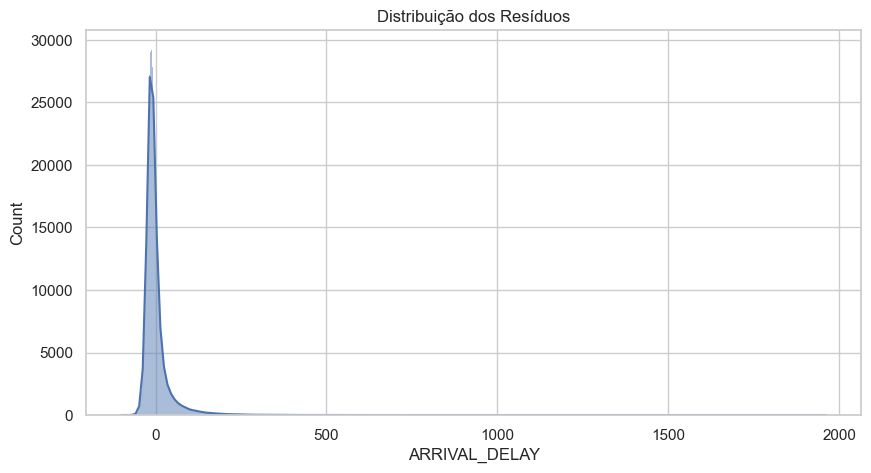

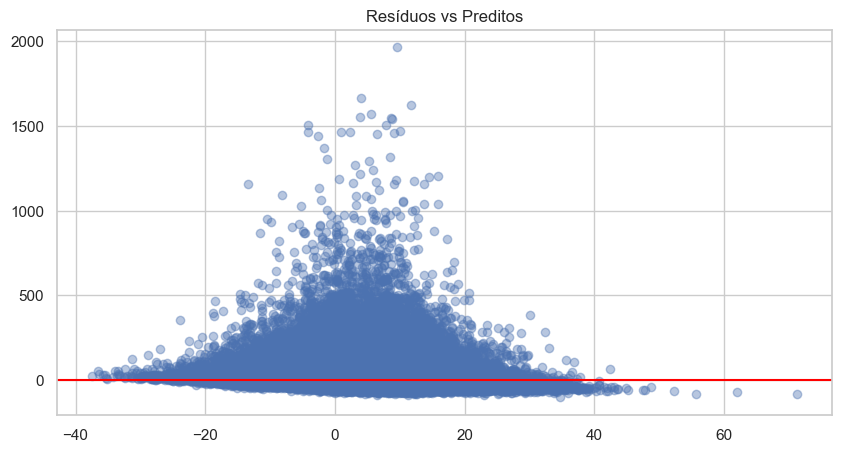

In [65]:
# ======== DIAGONÓSTICO DE RESÍDUOS ========

res = y_test - pred_multi

sns.histplot(res, kde=True)
plt.title("Distribuição dos Resíduos")
plt.show()

plt.scatter(pred_multi, res, alpha=0.4)
plt.axhline(0, color='red')
plt.title("Resíduos vs Preditos")
plt.show()

In [66]:
# ======== BASELINE DE CLASSIFICAÇÃO ========

baseline_clf = np.repeat(df["IS_DELAYED"].mode()[0], len(df))
print("Accuracy baseline:", accuracy_score(df["IS_DELAYED"], baseline_clf))

Accuracy baseline: 0.8208791447264338


In [67]:
# ======== CLASSIFICAÇÃO: NAIVE BAYES ========

X = df[["DISTANCE", "AIR_TIME", "DEP_HOUR"]]
y = df["IS_DELAYED"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

nb = GaussianNB()
nb.fit(X_train, y_train)

pred_nb = nb.predict(X_test)
proba_nb = nb.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, pred_nb))
print("Precision:", precision_score(y_test, pred_nb))
print("Recall:", recall_score(y_test, pred_nb))
print("F1:", f1_score(y_test, pred_nb))
print("ROC-AUC:", roc_auc_score(y_test, proba_nb))

Accuracy: 0.821178121844379
Precision: 0.2920353982300885
Recall: 0.00016151846939225004
F1: 0.0003228583727938011
ROC-AUC: 0.6071630619124175


In [68]:
# ======== CLASSIFICAÇÃO: REGRESSÃO LOGÍSTICA ========

log = LogisticRegression(max_iter=5000)
log.fit(X_train, y_train)

pred_log = log.predict(X_test)
proba_log = log.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, pred_log))
print("Precision:", precision_score(y_test, pred_log))
print("Recall:", recall_score(y_test, pred_log))
print("F1:", f1_score(y_test, pred_log))
print("ROC-AUC:", roc_auc_score(y_test, proba_log))

Accuracy: 0.8221695446805308
Precision: 0.7563739376770539
Recall: 0.007840987514132865
F1: 0.015521075042750776
ROC-AUC: 0.6304093839894024


In [69]:
# ======== OTIMIZAÇÃO COM GridSearchCV ========

param_grid = {"C": [0.01, 0.1, 1, 10]}

grid = GridSearchCV(
    LogisticRegression(max_iter=5000),
    param_grid,
    scoring="f1",
    cv=5
)

grid.fit(X_train, y_train)

print("Melhor parâmetro encontrado:", grid.best_params_)
print("Melhor F1-score (validação cruzada):", grid.best_score_)

# Avaliação no conjunto de teste
best_model = grid.best_estimator_
pred_grid = best_model.predict(X_test)
proba_grid = best_model.predict_proba(X_test)[:, 1]

print("\nDesempenho no conjunto de teste:")
print("Accuracy:", accuracy_score(y_test, pred_grid))
print("Precision:", precision_score(y_test, pred_grid))
print("Recall:", recall_score(y_test, pred_grid))
print("F1:", f1_score(y_test, pred_grid))
print("ROC-AUC:", roc_auc_score(y_test, proba_grid))

Melhor parâmetro encontrado: {'C': 0.01}
Melhor F1-score (validação cruzada): 0.014798341201047954

Desempenho no conjunto de teste:
Accuracy: 0.8221695446805308
Precision: 0.7563739376770539
Recall: 0.007840987514132865
F1: 0.015521075042750776
ROC-AUC: 0.630409396031498


# 🧠 Conclusões

## Insights da EDA
- Atrasos não seguem distribuição normal.
- Companhias apresentam diferenças estatísticas significativas.
- Horário de partida influencia atraso.
- Distância e air_time apresentam correlação moderada com atraso.

## Desempenho dos Modelos
- A regressão múltipla foi superior à simples e à polinomial.
- A regressão logística superou o Naive Bayes.
- Tuning melhorou o F1-score do modelo.

## Limitações
- Não há variáveis meteorológicas.
- Dataset pode conter registros inconsistentes.
- Classificação sofre com desbalanceamento de classes.